In [1]:
import logging
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3.units as u

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    get_planck_noise_data, 
    get_planck_hm_data, 
    get_map_dtype
    )
from cmbml.utils.fits_inspection import get_field_unit

from system_config import ASSETS_DIRECTORY, NOISE_DIRECTORY

In [2]:
# Logging was helpful when debugging my handle_data module
logging.basicConfig(
    level=logging.WARNING,  # If DEBUG, there's a bunch of PySM3 and Matplotlib stuff
    format='%(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

#### Helper functions

In [3]:
def get_unit_from_str(unit_str):
    if unit_str in ['uK_CMB']:
        return u.uK_CMB
    elif unit_str in ['Kcmb', 'K_CMB']:
        return u.K_CMB
    elif unit_str in ['MJy/sr']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

def get_sqrt_unit_from_str(unit_str):
    if unit_str in ['Kcmb^2', '(K_CMB)^2', 'K_CMB^2']:
        return u.K_CMB
    elif unit_str in ['uK_CMB^2', '(uK_CMB)^2']:
        return u.uK_CMB
    elif unit_str in ['(MJy/sr)^2', '(Mjy/sr)^2', 'MJy/sr^2']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

In [11]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"({ps_s[0].unit:latex_inline})"
    x_label="$\\ell$"
    plt.figure()
    ells = np.arange(len(ps_s[0])).astype(float)
    if x_low < 1:
        ells[0] = x_low
    for i, ps in enumerate(ps_s):
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [5]:
def nside2lmax(nside):
    return 2 * nside

# Parameters

In [17]:
DETECTORS = [30, 44, 70, 100, 143, 217, 353, 545, 857]
N_PLANCK_SIMS = 20

In [7]:
def get_ps(det):
    nside = 1024 if det < 99 else 2048  # detectors 30, 44, 70 are 1024, the rest are 2048
    all_ps = []
    for i in range(N_PLANCK_SIMS):
        nse_fn = get_planck_noise_data(detector=det, assets_directory=NOISE_DIRECTORY, realization=i)
        nse_unit = get_field_unit(nse_fn, hdu=1, field_idx=0)
        nse_unit = get_unit_from_str(nse_unit)
        nse_map = hp.read_map(nse_fn, field=0) * nse_unit
        if nse_unit == u.K_CMB:
            nse_map = nse_map.to(u.uK_CMB)
        new_cl = hp.anafast(nse_map, lmax = nside2lmax(nside))
        all_ps.append(new_cl*nse_map.unit**2)
    return all_ps

In [14]:
all_all_ps = {}
for detector in DETECTORS:
    all_ps = get_ps(detector)
    all_all_ps[detector] = all_ps.copy()

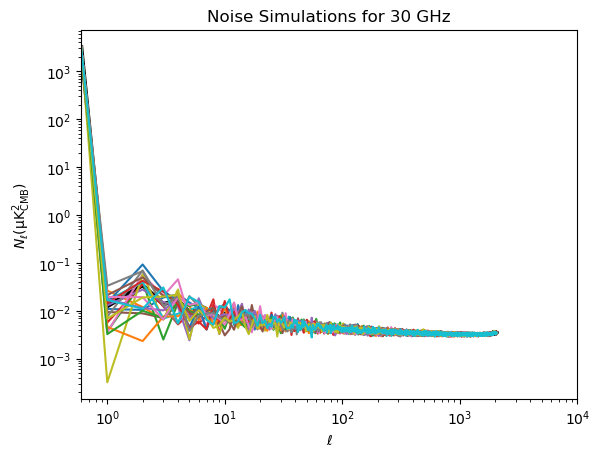

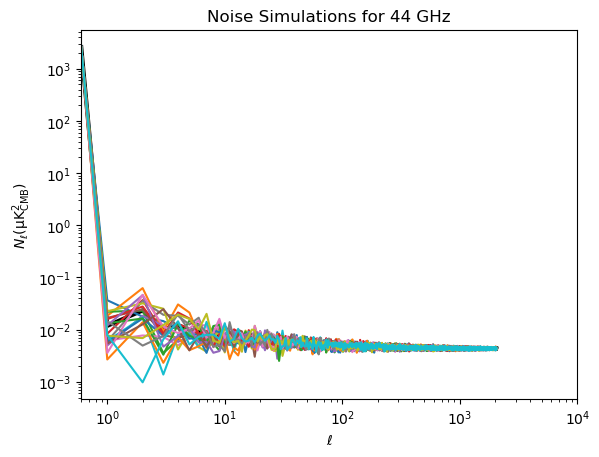

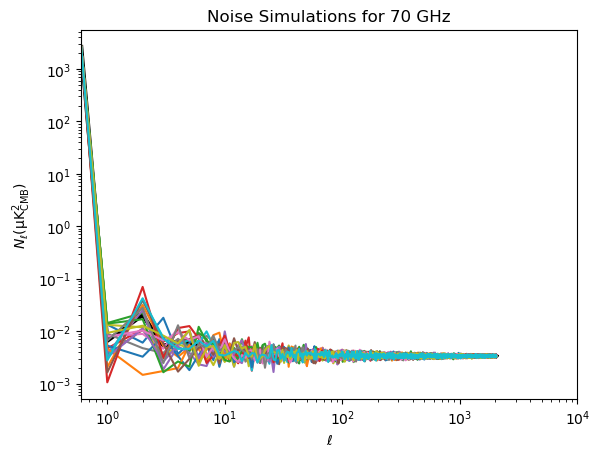

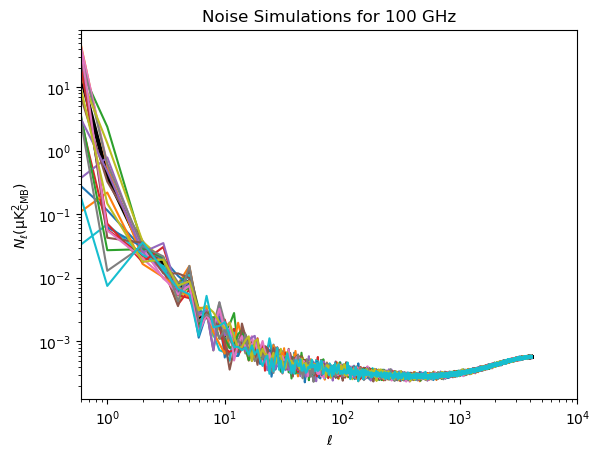

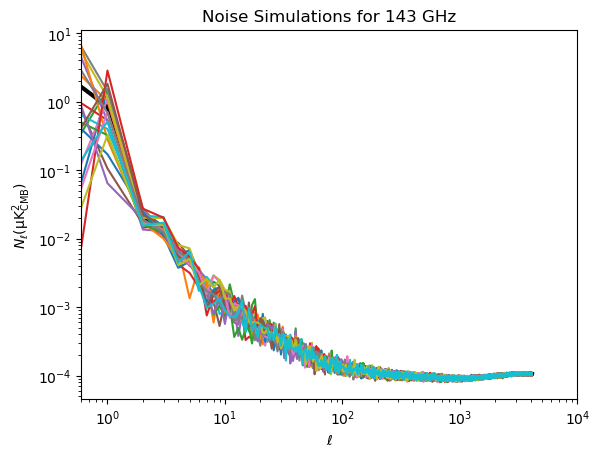

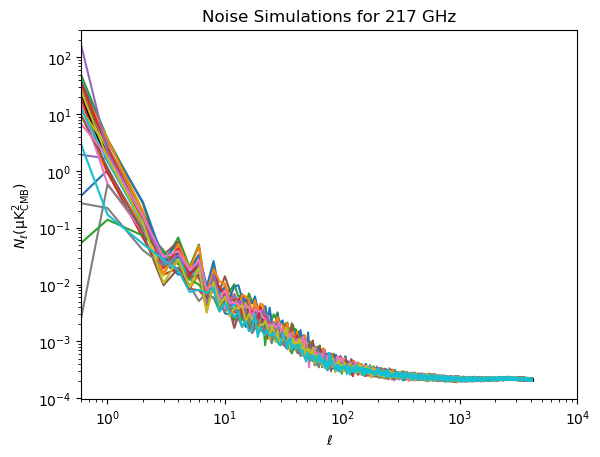

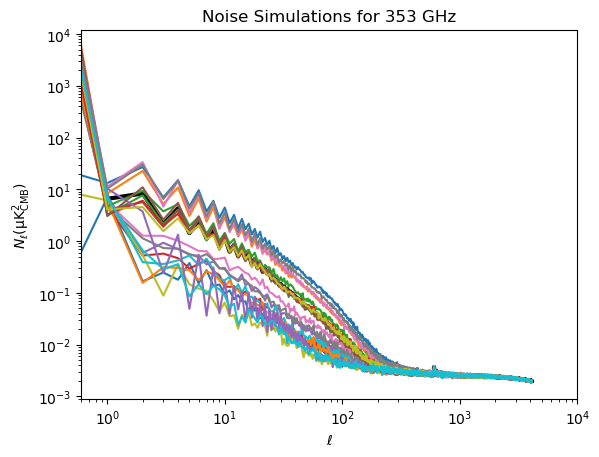

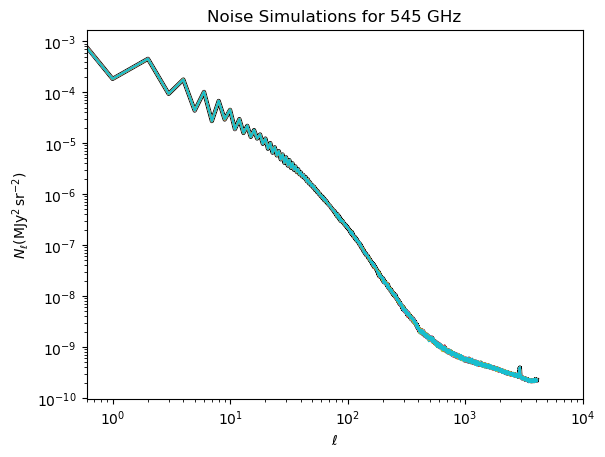

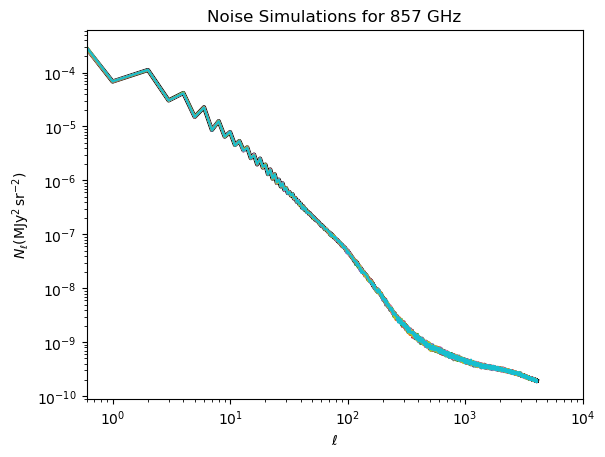

In [18]:
for detector in DETECTORS:
    all_ps = all_all_ps[detector]
    mean_ps = np.mean(all_ps, axis=0) * all_ps[0].unit
    plot_many_ps([mean_ps, *all_ps], 
                  title=f'Noise Simulations for {detector} GHz', 
                  labels=[f'Avg of {N_PLANCK_SIMS} Sims', *[f"Sim {i:04d}" for i in range(N_PLANCK_SIMS)]],
                  x_low=0.6, x_high=1e4, y_low=None, y_high=None, legend=False,
                  focus_first=True)